# Import do arquivo e transformações

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/Store Sales")

In [3]:
df = pd.read_csv('train.csv')

In [4]:
# Transformar a coluna de data em datetime
df['date'] = pd.to_datetime(df['date'])

# Remover 2017-08 da análise pois não é um mês completo
mask_1708 = df['date'].dt.strftime('%Y-%m').str.startswith('2017-08')
df = df[~mask_1708]

# Coluna de ano, trimestre e mês
df['ano'] = df['date'].dt.year 
df['mes'] = df['date'].dt.month 
df['trimestre'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str)).dt.to_period('Q')

# Adicionando id por grupo de ano e mês
df['yyyy_mm'] = df['ano'].astype(str) + '-' + df['mes'].astype(str)

# Transformando coluna string em int 'family'
mapeamento_valores_family = {}

for i, valor in enumerate(df['family'].unique()):
    mapeamento_valores_family[valor] = i

df['ft_family'] = df['family'].map(mapeamento_valores_family)

# Transformando coluna string em int 'trimestre'
mapeamento_valores_trimestre = {}

for i, valor in enumerate(df['trimestre'].unique()):
    mapeamento_valores_trimestre[valor] = i

df['trimestre_id'] = df['trimestre'].map(mapeamento_valores_trimestre)

# Range de datas
print("Data mínima:", df['date'].min())
print("Data máxima:", df['date'].max())

Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-07-31 00:00:00


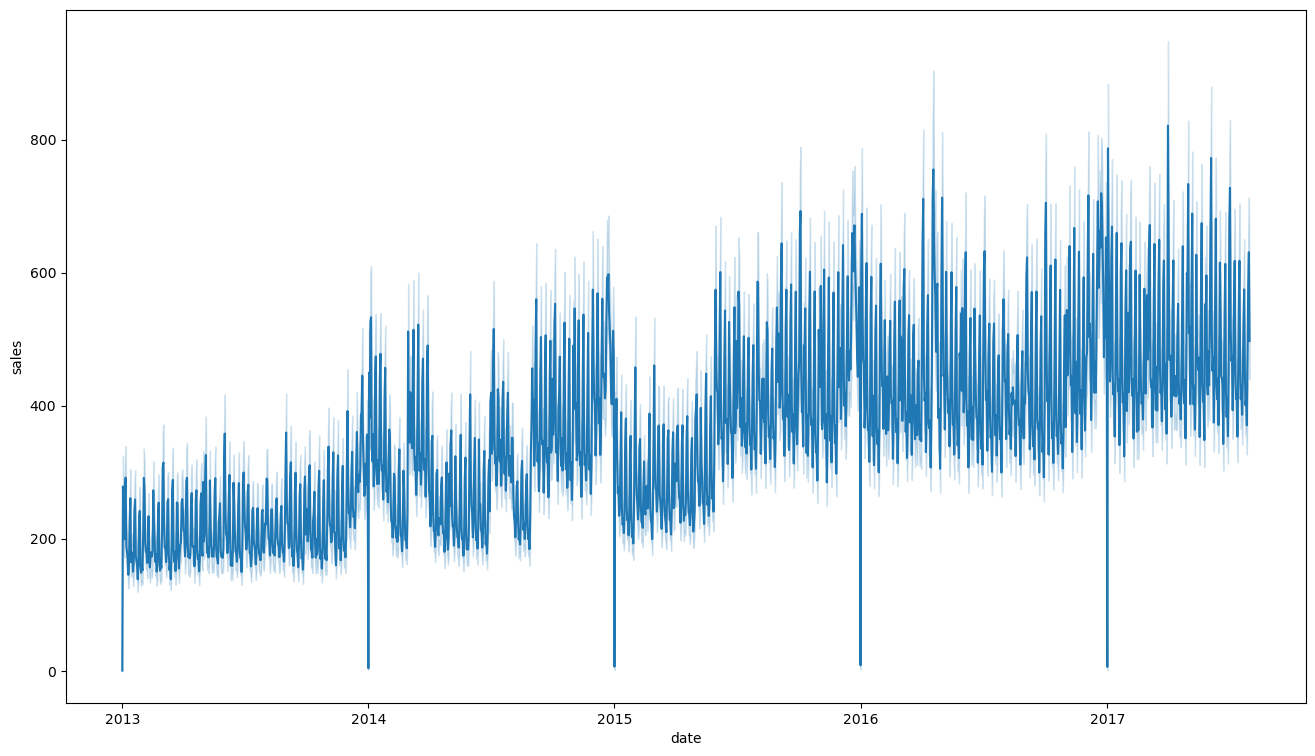

In [5]:
plt.figure(figsize = (16, 9))
sns.lineplot(x = df.date, y = df.sales)
plt.show()

In [6]:
# Renomear colunas para identificar as features ft_ e target tg_
renomear_colunas = {
    'store_nbr': 'ft_store',
    'onpromotion': 'ft_onpromotion',
    'ano': 'ft_ano',
    'mes': 'ft_mes',
    'sales': 'tg_sales'
}

df.rename(columns=renomear_colunas, inplace=True)

df.head()

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,trimestre,yyyy_mm,ft_family,trimestre_id
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,2013Q1,2013-1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,2013Q1,2013-1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,2013Q1,2013-1,2,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,2013Q1,2013-1,3,0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,2013Q1,2013-1,4,0


In [7]:
df['trimestre'].unique()

<PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3']
Length: 19, dtype: period[Q-DEC]

# Separando df de Teste

In [8]:
# Vamos separar o último trimestre para teste
df_teste = df[df['trimestre'] == '2017Q3']
df_teste.shape

(55242, 12)

In [9]:
# Separando os dados que sobraram para tv (treino e validação)
df_tv = df[df['trimestre'] != '2017Q3']
df_tv.shape

(2918916, 12)

# Prequential Expanding with gap

In [10]:
# Agora temos que dividir o dataset em treino e validação 

df_tv['trimestre_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [12]:
resultado_val = []

for iteration in range(1, 17):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] < iteration ]
    val = df_tv[df_tv['trimestre_id']  == iteration + 1]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4314

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4185

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4073

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4375

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4410

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4345

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4431

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4522

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4705

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4601

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4671

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4378

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4851

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [13]:
print(f'Média: {np.mean(resultado_val)}')
print(f'Median: {np.median(resultado_val)}')
print(f'Máximo: {np.max(resultado_val)}')
print(f'Mínimo: {np.min(resultado_val)}')
print(f'Desvio Padrão: {np.std(resultado_val)}')

Média: 0.4518447435850198
Median: 0.44764115431828544
Máximo: 0.4885755096189549
Mínimo: 0.407326989124134
Desvio Padrão: 0.023669808869699372


# Valor do df de Teste

In [14]:
X_test = df_teste.filter(regex = r'ft_')
y_test = df_teste['tg_sales']

predictions = pd.Series(modelo.predict(X_test))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_test, ranked_predictions)[0, 1]
correlation

0.49732572021622173